In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvista as pv
import SimpleITK as sitk
import scipy
from stl import mesh
# import stltovoxel
from scipy.ndimage import zoom
from skimage import filters
from skimage import exposure
import skimage.morphology as morph
from MedtoolFunctions import medtool_functions as mf

In [2]:
# Functions
def load_itk(filename):

    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    ct_scan = np.transpose(ct_scan, (2, 1, 0))

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    ct_trans = np.transpose(ct_scan, (1, 0, 2))
    ct_trans = ct_trans.astype(np.short)

    return ct_scan, origin, spacing

In [3]:
# Load the bone file for implantation

file = 'S131318_L4_left_screw_image.mhd'
path_bone = '/home/biomech/Documents/01_Icotec/01_Experiments/02_Scans/S131318_L4_left/04_Registered/'
zoom = 0.5
file = path_bone + file
# load bone sample
data_orig = load_itk(file)
data_img_orig = data_orig[0]
data_img_orig.shape

(438, 644, 1137)

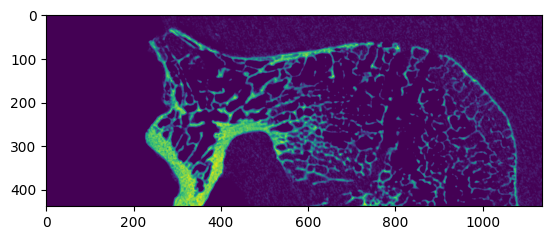

In [4]:
plt.imshow(data_img_orig[:, int(data_img_orig.shape[1]/2), :])

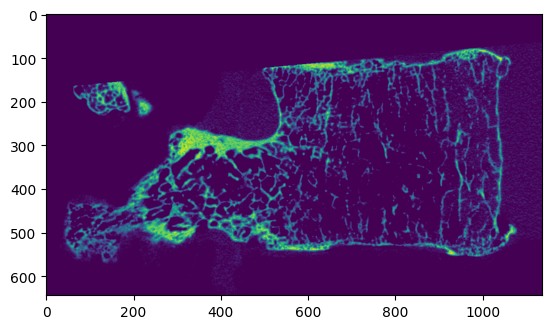

In [5]:
plt.imshow(data_img_orig[int(data_img_orig.shape[0]/2), :, :])

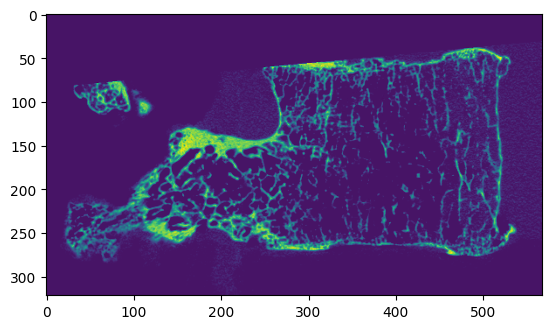

In [6]:
data_img = scipy.ndimage.zoom(data_img_orig, zoom)
plt.imshow(data_img[int(data_img.shape[0]/2), :, :])
reso = data_orig[2] / zoom

### Create mask for virtual implantation / insertion


In [7]:
# Load implant
path_implant = '/home/biomech/Documents/01_Icotec/02_FEA/01_MainStudy/S131318_L4_left/94_OSTP/'
#path_implant = '/home/biomech/Documents/01_Icotec/02_FEA/01_MainStudy/S131318_L4_left/81_L50_S50_D45_expl/'
#implant = 'S131318_L4_left_screw.mhd'
implant = '94_OSTP_mask.mhd'
#screw ='NA'
#reso = 0.0606995 / zoom
imp_data_orig = load_itk(path_implant + implant)
imp_img = scipy.ndimage.zoom(imp_data_orig[0], zoom)
imp_img = np.flip(np.swapaxes(imp_img, 0, 2), 1)
imp_img = imp_img[:, ::-1, :]
print(imp_img.shape)
sitk.WriteImage(sitk.GetImageFromArray(imp_img), '/home/biomech/Downloads/FE_test/screw_test.mhd')

(66, 66, 412)


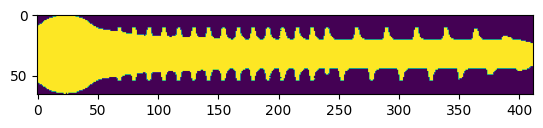

In [8]:
# Cut the upper part according to the offset
#path_simInfo = 'C:/Users/kirta/OneDrive - Universitaet Bern/01_MBArtorg/2021_Projects/2021_Schroedinger/04_SampleInfos/05_IMG_cropped_orientation/'
#file_rot = path_simInfo + sample + '_PILOT_CUTsimInfo.txt'
#df = pd.read_csv(file_rot)
#h = df.startPoint
#h = int(np.round(h * 0.0245/0.072, 0))

#L_tot = int(round(12.50 / 0.072, 0))
#start = int(L_tot + h)
#imp_img = imp_img[:,:, :start]

#imp_img = np.swapaxes(imp_img, 2, 0)

plt.imshow(imp_img[:, int(imp_img.shape[1]/2), :])


In [9]:
#L_tot * 0.072

In [10]:
#imp_img.shape, L_tot

In [11]:
# Enlargement of the implant - so there will be a small gap between implant and bone for the start of the simulation

# defines the size of the gap
blow = 1

add_l = np.zeros([imp_img.shape[0], imp_img.shape[1], blow])
mask = np.concatenate([add_l, imp_img, add_l], 2)

add_x = np.zeros([blow, mask.shape[1], mask.shape[2]])
mask = np.concatenate([add_x, mask, add_x], 0)

add_y = np.zeros([mask.shape[0], blow, mask.shape[2]])
mask = np.concatenate([add_y, mask, add_y], 1)

footprint = morph.ball(blow)
mask_zoom = morph.dilation(mask, footprint)

diff_mask = mask_zoom - mask

print(imp_img.shape, mask_zoom.shape, mask.shape)

(66, 66, 412) (68, 68, 414) (68, 68, 414)


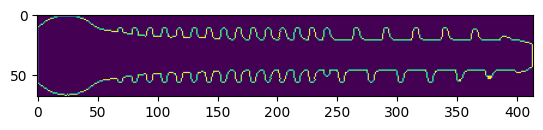

In [12]:
plt.imshow(diff_mask[:, int(diff_mask.shape[1]/2), :])

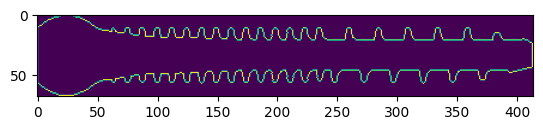

In [13]:
plt.imshow(diff_mask[int(diff_mask.shape[0]/2), : ,  :])

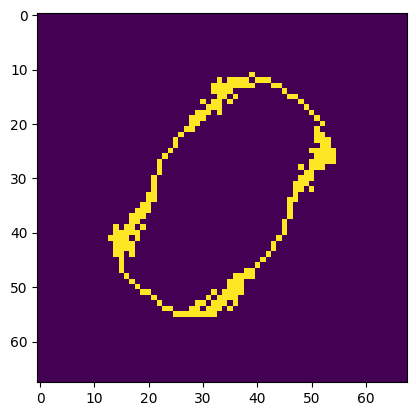

In [14]:
plt.imshow(diff_mask[ : , :, int(diff_mask.shape[2]/2)])

In [15]:
# Match the mask to the same size as the bone
# Real origin
Orig_vox = [np.rint(-data_orig[1]/reso).astype(int)[2],
            np.rint(-data_orig[1]/reso).astype(int)[1],
            np.rint(-data_orig[1]/reso).astype(int)[0]]
orig_vox = [Orig_vox[0], Orig_vox[1], Orig_vox[2]-blow]
print(Orig_vox)
print(orig_vox)
print(mask_zoom.shape)
print(data_img.shape)

[116, 193, 398]
[116, 193, 397]
(68, 68, 414)
(219, 322, 568)


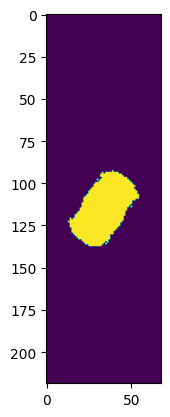

In [16]:

#add1 = np.zeros([int((data_img.shape[0] - mask_zoom.shape[0]) / 2), mask_zoom.shape[1], mask_zoom.shape[2]])
#add2 = np.zeros([int((data_img.shape[0] - mask_zoom.shape[0]) / 2), mask_zoom.shape[1], mask_zoom.shape[2]])
add1 = np.zeros([orig_vox[0] - int(mask_zoom.shape[0]/2), mask_zoom.shape[1], mask_zoom.shape[2]])
add2 = np.zeros([data_img.shape[0] - orig_vox[0] - int(mask_zoom.shape[0]/2), mask_zoom.shape[1], mask_zoom.shape[2]])
mask_zoom2 = np.concatenate([add1, mask_zoom, add2], 0)

plt.imshow(mask_zoom2[:, :, int(mask_zoom2.shape[2]/2)])


In [17]:
mask_zoom.shape  #, add1.shape, add2.shape

(68, 68, 414)

414
397


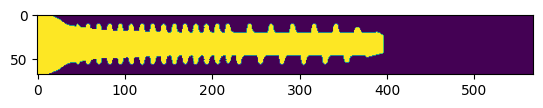

In [18]:

#add5 = np.zeros([mask_zoom.shape[0], mask_zoom.shape[1], int((data_img.shape[2] - mask_zoom.shape[2]) / 2)])

print(mask_zoom2.shape[2])
print(orig_vox[2])
if mask_zoom2.shape[2] > orig_vox[2]:
    mask_zoom22 = mask_zoom2[:, :, mask_zoom2.shape[2] - orig_vox[2]:]
add5 = np.zeros([mask_zoom22.shape[0], mask_zoom22.shape[1], orig_vox[2] - mask_zoom22.shape[2]])
#add6 = np.zeros([mask_zoom.shape[0], mask_zoom.shape[1], int((data_img.shape[2] - mask_zoom.shape[2]) / 2)])
add6 = np.zeros([mask_zoom22.shape[0], mask_zoom22.shape[1], data_img.shape[2] - orig_vox[2]])
mask_zoom3 = np.concatenate([add5, mask_zoom22, add6], 2)

#if mask_zoom.shape[2] < data_img.shape[2]:
#    diff = data_img.shape[2] - mask_zoom.shape[2]
#    add6_ = np.zeros([mask_zoom.shape[0], mask_zoom.shape[1], int(diff)])
#    mask_zoom = np.concatenate([mask_zoom, add6_], 2)

plt.imshow(mask_zoom3[orig_vox[0], :, :])

In [19]:
print(mask_zoom3.shape)
print(orig_vox)
#, add5.shape, add6.shape

(219, 68, 568)
[116, 193, 397]


193
34.0
322


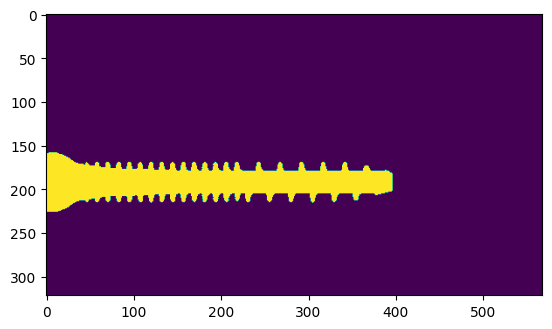

In [20]:
# Add material at the bottem
#add4 = np.zeros([mask_zoom.shape[0], int(data_img.shape[1] - mask_zoom.shape[1]), mask_zoom.shape[2]])
print(orig_vox[1])
print(mask_zoom3.shape[1]/2)
print(data_img.shape[1])
add3 = np.zeros([mask_zoom3.shape[0], orig_vox[1] - int(mask_zoom3.shape[1]/2), mask_zoom3.shape[2]])
add4 = np.zeros([mask_zoom3.shape[0], data_img.shape[1] - orig_vox[1] - int(mask_zoom3.shape[1]/2), mask_zoom3.shape[2]])
mask_zoom4 = np.concatenate([add3, mask_zoom3, add4], 1)

plt.imshow(mask_zoom4[orig_vox[0], :, :])

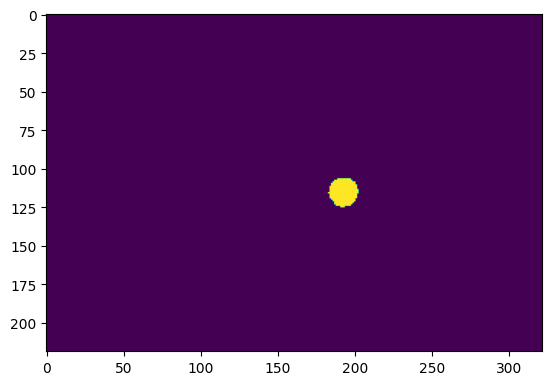

In [21]:
plt.imshow(mask_zoom4[:, :, orig_vox[2]-1])

In [22]:
mask_zoom4.shape

(219, 322, 568)

360


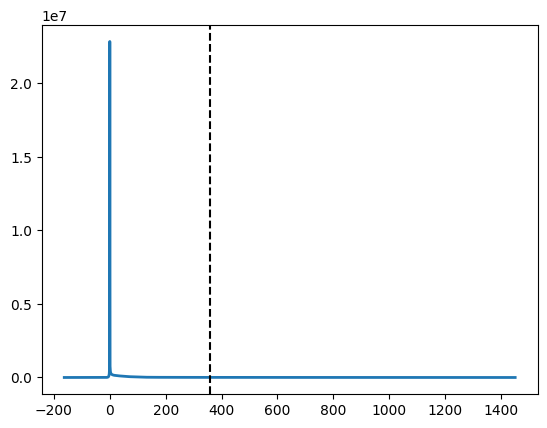

In [23]:
# Combine screw mask with bone
mask_zoom4_ = np.abs(mask_zoom4-1)
data_bvtv = np.array((data_img > 320).astype(int))
vir_img = np.array(mask_zoom4_ * data_img)

val = filters.threshold_otsu(data_img)
print(val)
hist, bins_center = exposure.histogram(data_img)
vir_bvtv = np.array((vir_img > val).astype(int))
plt.figure()
plt.plot(bins_center, hist, lw=2)
plt.axvline(val, color='k', ls='--')
plt.show()

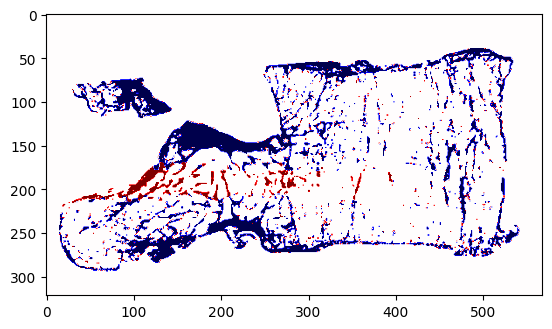

In [24]:
plt.imshow(vir_bvtv[orig_vox[0], :, :]*-2+data_bvtv[orig_vox[0], :, :], cmap='seismic')

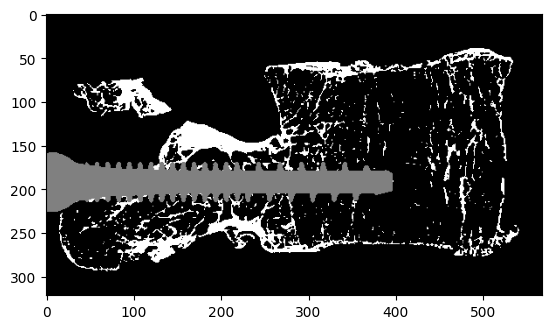

In [25]:
plt.imshow(vir_bvtv[orig_vox[0], :, :]*2 + mask_zoom4[orig_vox[0], :, :], cmap='gray')

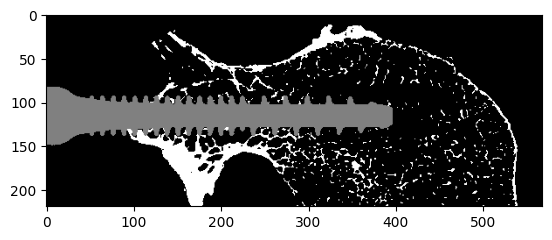

In [26]:
plt.imshow(vir_bvtv[:, orig_vox[1], :]*2 + mask_zoom4[:, orig_vox[1], :], cmap='gray')

In [44]:
mask_dim = [-5.75, 5.75,
            -8.75, 8.75,
            -45, 5]
roi_dim_vox = np.rint(mask_dim / reso[1]).astype(int)
orig_vox_roi = [-roi_dim_vox[0], -roi_dim_vox[2], -roi_dim_vox[4]-blow]
print(roi_dim_vox)
vir_bvtv_roi = vir_bvtv[orig_vox[0]+roi_dim_vox[0]:orig_vox[0]+roi_dim_vox[1],
                        orig_vox[1]+roi_dim_vox[2]:orig_vox[1]+roi_dim_vox[3],
                        orig_vox[2]+roi_dim_vox[4]:orig_vox[2]+roi_dim_vox[5]]
mask_zoom4_roi = mask_zoom4[orig_vox[0]+roi_dim_vox[0]:orig_vox[0]+roi_dim_vox[1],
                            orig_vox[1]+roi_dim_vox[2]:orig_vox[1]+roi_dim_vox[3],
                            orig_vox[2]+roi_dim_vox[4]:orig_vox[2]+roi_dim_vox[5]]

add1 = np.zeros([orig_vox[0] - int(mask.shape[0]/2), mask.shape[1], mask.shape[2]])
add2 = np.zeros([data_img.shape[0] - orig_vox[0] - int(mask.shape[0]/2), mask.shape[1], mask.shape[2]])
mask_roi0 = np.concatenate([add1, mask, add2], 0)

add3 = np.zeros([mask_roi0.shape[0], orig_vox[1] - int(mask_roi0.shape[1]/2), mask_roi0.shape[2]])
add4 = np.zeros([mask_roi0.shape[0], data_img.shape[1] - orig_vox[1] - int(mask_roi0.shape[1]/2), mask_roi0.shape[2]])
mask_roi1 = np.concatenate([add3, mask_roi0, add4], 1)


if mask_roi1.shape[2] > orig_vox[2]:
    mask_roi11 = mask_roi1[:, :, mask_roi1.shape[2] - orig_vox[2]:]
add5 = np.zeros([mask_roi11.shape[0], mask_roi11.shape[1], orig_vox[2] - mask_roi11.shape[2]])

add6 = np.zeros([mask_roi11.shape[0], mask_roi11.shape[1], data_img.shape[2] - orig_vox[2]])

mask_roi2 = np.concatenate([add5, mask_roi11, add6], 2)

mask_roi = mask_roi2[orig_vox[0]+roi_dim_vox[0]:orig_vox[0]+roi_dim_vox[1],
                            orig_vox[1]+roi_dim_vox[2]:orig_vox[1]+roi_dim_vox[3],
                            orig_vox[2]+roi_dim_vox[4]:orig_vox[2]+roi_dim_vox[5]]

print(mask_zoom4_roi.shape)
print(vir_bvtv_roi.shape)
print(mask_roi.shape)
print(mask.shape)

[ -47   47  -72   72 -371   41]
(94, 144, 412)
(94, 144, 412)
(94, 144, 412)
(68, 68, 414)


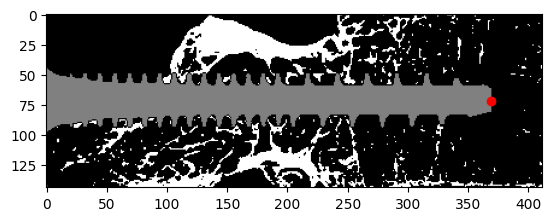

In [45]:
plt.imshow(vir_bvtv_roi[int(vir_bvtv_roi.shape[0]/2), :, :]*2 + mask_roi[int(vir_bvtv_roi.shape[0]/2), :, :], cmap='gray')
plt.scatter(orig_vox_roi[2]-blow, orig_vox_roi[1], color='r')

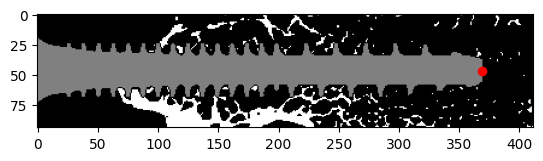

In [46]:
plt.imshow(vir_bvtv_roi[:, int(vir_bvtv_roi.shape[1]/2), :]*2 + mask_roi[:, int(vir_bvtv_roi.shape[1]/2), :], cmap='gray')
plt.scatter(orig_vox_roi[2]-blow, orig_vox_roi[0], color='r')

In [38]:
# Create .mhd of mesh image

origin = [0, 0, 0]
spacing = np.array([1, 1, 1]) * reso[1]
cylinder_trans = vir_bvtv_roi.astype(np.short)
itkimage = sitk.GetImageFromArray(np.transpose(cylinder_trans, [2, 1, 0]), isVector=None)
itkimage.SetSpacing(spacing)
itkimage.SetOrigin(origin)

mask_trans = mask_roi.astype(np.short)
itkmask = sitk.GetImageFromArray(np.transpose(mask_trans ,[2, 1, 0]), isVector=None)
itkmask.SetSpacing(spacing)
itkmask.SetOrigin(origin)

path_to_local_folder = '/home/biomech/Downloads/FE_test/'
reso_ = '0' + str(reso[1]).split('.')[-1]
sitk.WriteImage(itkimage, path_to_local_folder + 'Mesh_' + 'test' + '_' + reso_ + '_test00.mhd')
sitk.WriteImage(itkmask, path_to_local_folder + 'Implant_mask_' + reso_ + '.mhd')

In [39]:
# Creat abaqus mesh

def mesh(img, path, storage, name, template):
    img = path + img

    img, origin, spacing = load_itk(img)

    inpName = storage + name

    mf.writeAbaqusGeneral(inpName, img, spacing, templateFile=template, smooth=None)

sample = 'test'
screw = 'ico'

img = 'Mesh_' + sample + '_' + reso_ + '_test00.mhd'
path = path_to_local_folder
# template = 'C:/Users/kirta/OneDrive - Universitaet Bern/01_MBArtorg/2021_Projects/2021_Schroedinger/' \
#            '03_Simulations/01_Meshes/mesh_temp_home.inp'
template = path + 'mesh_temp.inp'
mesh(img, path, path, 'Mesh_' + sample + '_' + reso_ + screw + 'test0.inp', template)

 ... setup ABAQUS *.inp file from template
     -> recast model from 'h' to 'i'
     -> setup Element Data  : |==========|
     -> setup Node Data     : Done
 ... write ABAQUS *.inp file from template
     -> process Node IDs    : |==========|
     -> write Nodes         :    1359592 
     -> process Elements    : |=|
     -> write Elements      :     824242             
     -> write BCs Node Sets     
     -> Write Property      : /home/biomech/Downloads/FE_test/vumat.inp 
     -> Write finished in   :        9.8 sec  


In [40]:
img_screw = 'Implant_mask_' + reso_ + '.mhd'
path = path_to_local_folder
template = path + 'mesh_temp.inp'
mesh(img_screw, path, path, 'Mesh_' + sample + '_' + reso_ + screw + 'screw.inp', template)

 ... setup ABAQUS *.inp file from template
     -> recast model from 'h' to 'i'
     -> setup Element Data  : |==========|
     -> setup Node Data     : Done
 ... write ABAQUS *.inp file from template
     -> process Node IDs    : |==========|
     -> write Nodes         :     352555 
     -> process Elements    : |=|
     -> write Elements      :     303113             
     -> write BCs Node Sets     
     -> Write Property      : /home/biomech/Downloads/FE_test/vumat.inp 
     -> Write finished in   :        4.8 sec  
